**Libraries**

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import time


**Task 1/ Task2**

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Method		Accuracy	Precision	Recall		F1		Train Time(s)	Test Time(s)
Scratch MLP	0.9474		0.9714		0.9444		0.9577		0.2885		0.000053
sklearn MLP	0.9649		0.9857		0.9583		0.9718		0.7188		0.000696

Classification report - sklearn MLP (test):
              precision    recall  f1-score   support

   malignant       0.93      0.98      0.95        42
      benign       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



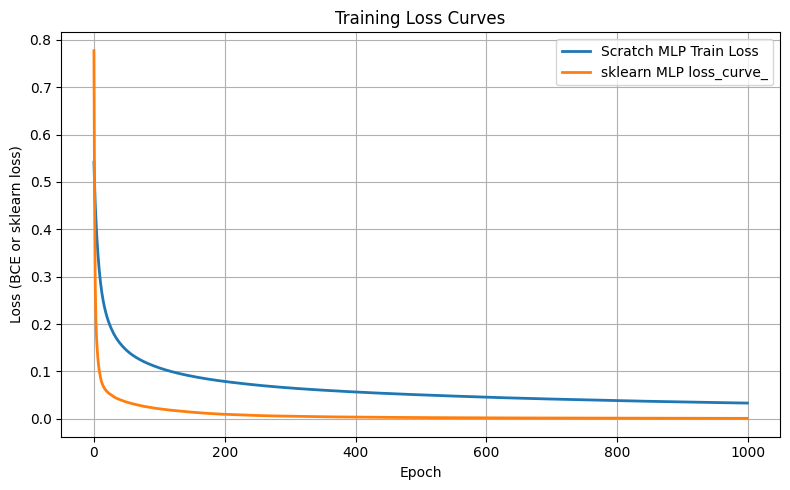


Confusion matrix - Scratch MLP (test):


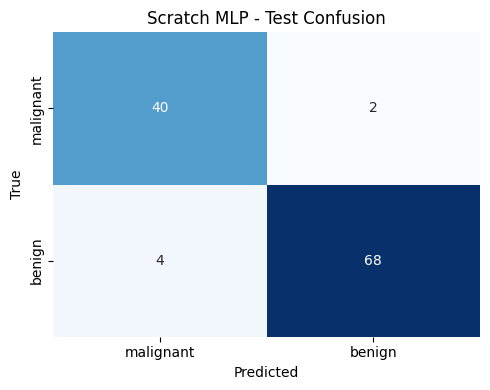

Confusion matrix - sklearn MLP (test):


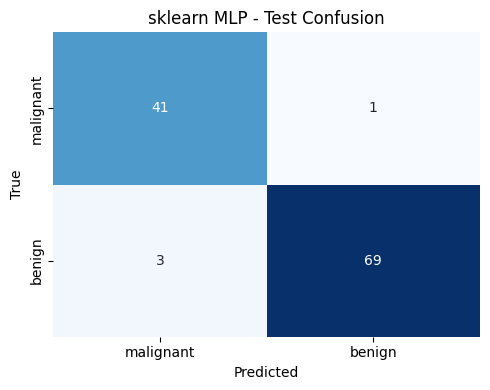

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.learning_rate = learning_rate
        self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        x = np.clip(x, -250, 250)
        return 1.0 / (1.0 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivate(self, x):
        return (x > 0).astype(float)

    def forward(self, x):
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def compute_loss(self, y_true, y_pred):
        eps = 1e-12
        return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

    def backward(self, x, y_true, y_pred):
        m = y_true.shape[0]
        dz2 = (y_pred - y_true) / m
        dw2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = np.dot(dz2, self.w2.T)
        dz1 = da1 * self.relu_derivate(self.z1)
        dw1 = np.dot(x.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        return dw1, db1, dw2, db2

    def update_parameters(self, dw1, db1, dw2, db2):
        self.w1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.w2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2

    def train(self, x_train, y_train, x_val=None, y_val=None, epochs=1000, batch_size=None, verbose=True):
        n = x_train.shape[0]
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(1, epochs + 1):
            if batch_size is None:
                y_pred_train = self.forward(x_train)
                train_loss = self.compute_loss(y_train, y_pred_train)
                train_losses.append(train_loss)
                train_pred_labels = (y_pred_train > 0.5).astype(int)
                train_acc = np.mean(train_pred_labels == y_train)
                train_accuracies.append(train_acc)
                dw1, db1, dw2, db2 = self.backward(x_train, y_train, y_pred_train)
                self.update_parameters(dw1, db1, dw2, db2)
            else:
                perm = np.random.permutation(n)
                x_shuf = x_train[perm]
                y_shuf = y_train[perm]
                epoch_loss = 0.0
                epoch_correct = 0
                nbatches = int(np.ceil(n / batch_size))
                for b in range(nbatches):
                    start = b * batch_size
                    end = min(start + batch_size, n)
                    xb = x_shuf[start:end]
                    yb = y_shuf[start:end]
                    y_pred_b = self.forward(xb)
                    batch_loss = self.compute_loss(yb, y_pred_b)
                    epoch_loss += batch_loss * xb.shape[0]
                    preds_b = (y_pred_b > 0.5).astype(int)
                    epoch_correct += np.sum(preds_b == yb)
                    dw1, db1, dw2, db2 = self.backward(xb, yb, y_pred_b)
                    self.update_parameters(dw1, db1, dw2, db2)
                train_loss = epoch_loss / n
                train_losses.append(train_loss)
                train_acc = epoch_correct / n
                train_accuracies.append(train_acc)

            if x_val is not None and y_val is not None:
                y_pred_val = self.forward(x_val)
                val_loss = self.compute_loss(y_val, y_pred_val)
                val_losses.append(val_loss)
                val_acc = np.mean((y_pred_val > 0.5).astype(int) == y_val)
                val_accuracies.append(val_acc)
            else:
                val_loss = None
                val_acc = None

            if verbose and (epoch % 100 == 0 or epoch == 1 or epoch == epochs):
                if x_val is not None and y_val is not None:
                    print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")
                else:
                    print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}")

        return train_losses, train_accuracies, val_losses, val_accuracies

    def predict(self, x, threshold=0.5):
        y_proba = self.forward(x)
        return (y_proba >= threshold).astype(int)

    def predict_proba(self, x):
        return self.forward(x)

def load_and_prepare_data():
    data = load_breast_cancer()
    X = data.data
    y = data.target.reshape(-1, 1).astype(float)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, data.feature_names, data.target_names

def plot_loss_curves(scratch_losses, sklearn_losses):
    plt.figure(figsize=(8,5))
    plt.plot(scratch_losses, label='Scratch MLP Train Loss', linewidth=2)
    if sklearn_losses is not None:
        plt.plot(sklearn_losses, label='sklearn MLP loss_curve_', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCE or sklearn loss)')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['malignant','benign'], yticklabels=['malignant','benign'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    return cm

def compare_models():
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names, target_names = load_and_prepare_data()
    input_size = X_train.shape[1]
    hidden_size = 16
    output_size = 1
    lr = 0.05
    epochs = 1000
    batch_size = None

    scratch = MLP(input_size, hidden_size, output_size, learning_rate=lr, seed=123)
    t0 = time.time()
    scratch_losses, scratch_accs, scratch_val_losses, scratch_val_accs = scratch.train(
        X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, verbose=False
    )
    train_time_scratch = time.time() - t0

    t0 = time.time()
    y_proba_test_scratch = scratch.predict_proba(X_test).ravel()
    y_pred_test_scratch = (y_proba_test_scratch >= 0.5).astype(int).reshape(-1,1)
    test_time_scratch = time.time() - t0

    scratch_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test_scratch),
        'precision': precision_score(y_test, y_pred_test_scratch),
        'recall': recall_score(y_test, y_pred_test_scratch),
        'f1': f1_score(y_test, y_pred_test_scratch)
    }

    mlp_sklearn = MLPClassifier(hidden_layer_sizes=(hidden_size,),
                                activation='relu',
                                solver='sgd',
                                learning_rate_init=lr,
                                max_iter=epochs,
                                batch_size='auto',
                                tol=1e-8,
                                random_state=123,
                                verbose=False)

    y_train_1d = y_train.ravel()
    y_val_1d = y_val.ravel()
    y_test_1d = y_test.ravel()

    t0 = time.time()
    mlp_sklearn.fit(X_train, y_train_1d)
    train_time_sklearn = time.time() - t0

    t0 = time.time()
    y_proba_test_sklearn = mlp_sklearn.predict_proba(X_test)[:, 1]
    y_pred_test_sklearn = (y_proba_test_sklearn >= 0.5).astype(int).reshape(-1,1)
    test_time_sklearn = time.time() - t0

    sklearn_metrics = {
        'accuracy': accuracy_score(y_test_1d, y_pred_test_sklearn.ravel()),
        'precision': precision_score(y_test_1d, y_pred_test_sklearn.ravel()),
        'recall': recall_score(y_test_1d, y_pred_test_sklearn.ravel()),
        'f1': f1_score(y_test_1d, y_pred_test_sklearn.ravel())
    }

    print("\nMethod\t\tAccuracy\tPrecision\tRecall\t\tF1\t\tTrain Time(s)\tTest Time(s)")
    print(f"Scratch MLP\t{scratch_metrics['accuracy']:.4f}\t\t{scratch_metrics['precision']:.4f}\t\t{scratch_metrics['recall']:.4f}\t\t{scratch_metrics['f1']:.4f}\t\t{train_time_scratch:.4f}\t\t{test_time_scratch:.6f}")
    print(f"sklearn MLP\t{sklearn_metrics['accuracy']:.4f}\t\t{sklearn_metrics['precision']:.4f}\t\t{sklearn_metrics['recall']:.4f}\t\t{sklearn_metrics['f1']:.4f}\t\t{train_time_sklearn:.4f}\t\t{test_time_sklearn:.6f}")

    print("\nClassification report - sklearn MLP (test):")
    print(classification_report(y_test_1d, y_pred_test_sklearn.ravel(), target_names=feature_names[:2] if False else ['malignant','benign']))

    sklearn_loss_curve = getattr(mlp_sklearn, 'loss_curve_', None)
    plot_loss_curves(scratch_losses, sklearn_loss_curve)

    print("\nConfusion matrix - Scratch MLP (test):")
    plot_confusion(y_test, y_pred_test_scratch, title='Scratch MLP - Test Confusion')

    print("Confusion matrix - sklearn MLP (test):")
    plot_confusion(y_test, y_pred_test_sklearn, title='sklearn MLP - Test Confusion')

    return {
        'scratch': {'metrics': scratch_metrics, 'train_time': train_time_scratch, 'test_time': test_time_scratch},
        'sklearn': {'metrics': sklearn_metrics, 'train_time': train_time_sklearn, 'test_time': test_time_sklearn},
        'mlp_sklearn': mlp_sklearn,
        'scratch_model': scratch
    }

if __name__ == "__main__":
    results = compare_models()


**Task 3/ Task 4**


Kernel: linear, params: {}, lambda=0.01
Scratch -> RMSE: 10.0676, R2: 0.9937, train_time: 0.0093s, test_time: 0.000334s
sklearn -> RMSE: 11.0483, R2: 0.9924, train_time: 0.0078s, test_time: 0.001688s


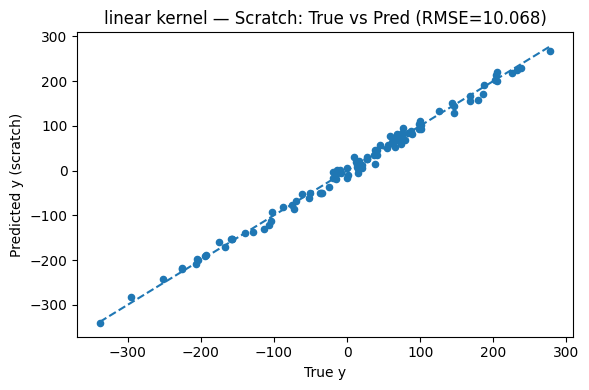

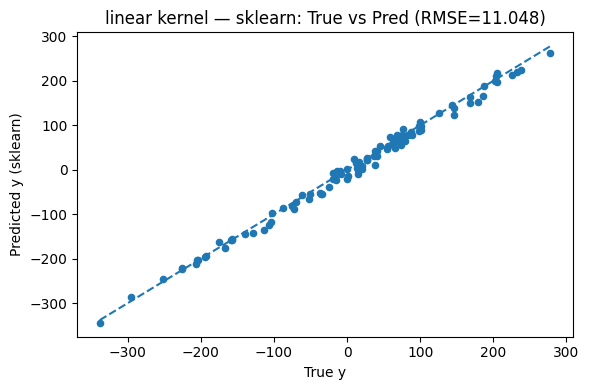


Kernel: poly, params: {'degree': 2}, lambda=0.01
Scratch -> RMSE: 11.5554, R2: 0.9917, train_time: 0.0149s, test_time: 0.000560s
sklearn -> RMSE: 11.5490, R2: 0.9917, train_time: 0.0103s, test_time: 0.001492s


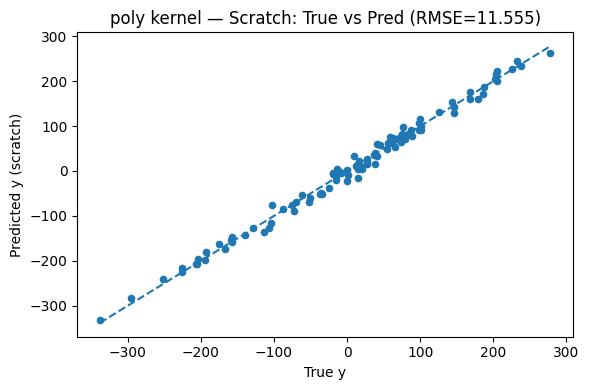

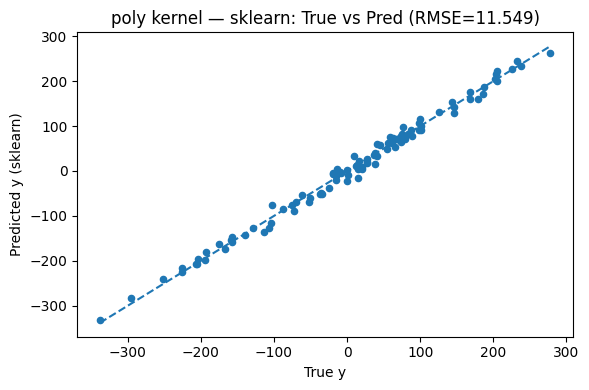


Kernel: poly, params: {'degree': 3}, lambda=0.01
Scratch -> RMSE: 31.3316, R2: 0.9392, train_time: 0.0281s, test_time: 0.002203s
sklearn -> RMSE: 27.3527, R2: 0.9536, train_time: 0.0939s, test_time: 0.002878s


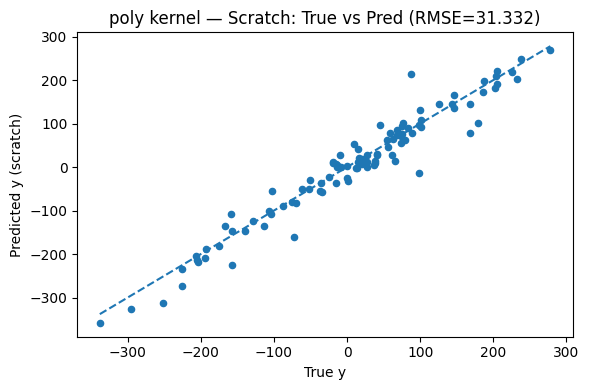

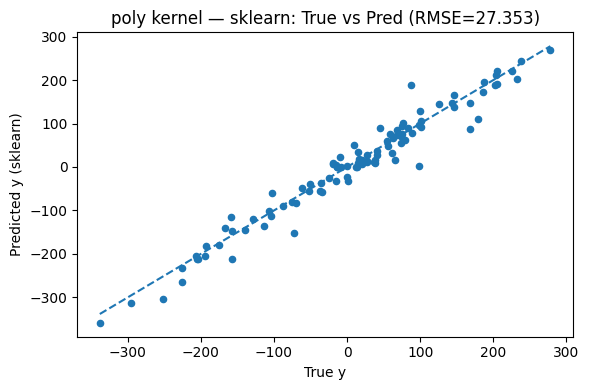


Kernel: rbf, params: {'gamma': 0.1}, lambda=0.01
Scratch -> RMSE: 31.8374, R2: 0.9372, train_time: 0.0128s, test_time: 0.001364s
sklearn -> RMSE: 31.8349, R2: 0.9372, train_time: 0.0117s, test_time: 0.003288s


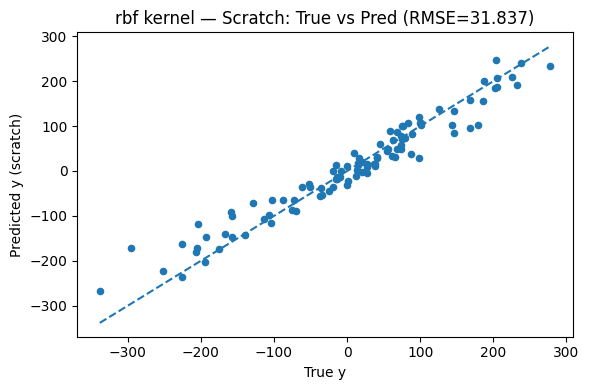

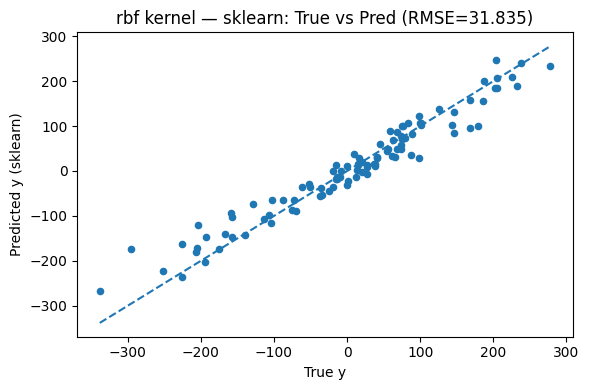


Summary (test set):
Kernel		Method	RMSE	R2	TrainTime(s)	TestTime(s)
linear      	Scratch	10.0676	0.9937	0.0093	0.000334
linear      	sklearn 	11.0483	0.9924	0.0078	0.001688
poly(d=2)   	Scratch	11.5554	0.9917	0.0149	0.000560
poly(d=2)   	sklearn 	11.5490	0.9917	0.0103	0.001492
poly(d=3)   	Scratch	31.3316	0.9392	0.0281	0.002203
poly(d=3)   	sklearn 	27.3527	0.9536	0.0939	0.002878
rbf         	Scratch	31.8374	0.9372	0.0128	0.001364
rbf         	sklearn 	31.8349	0.9372	0.0117	0.003288


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge

def linear_kernel(X, Y):
    return X.dot(Y.T)

def poly_kernel(X, Y, degree=2, coef0=1.0):
    return (X.dot(Y.T) + coef0) ** degree

def rbf_kernel(X, Y, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    X_norm = np.sum(X ** 2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y ** 2, axis=1).reshape(1, -1)
    dists = X_norm + Y_norm - 2.0 * X.dot(Y.T)
    return np.exp(-gamma * dists)

class KernelRidgeScratch:
    def __init__(self, kernel='linear', lam=1e-3, degree=2, coef0=1.0, gamma=None):
        self.kernel = kernel
        self.lam = lam
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.X_train = None
        self.alpha = None
        self.y_mean = 0.0

    def _compute_kernel(self, A, B):
        if self.kernel == 'linear':
            return linear_kernel(A, B)
        elif self.kernel == 'poly':
            return poly_kernel(A, B, degree=self.degree, coef0=self.coef0)
        elif self.kernel == 'rbf':
            return rbf_kernel(A, B, gamma=self.gamma)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

    def fit(self, X, y):
        """
        X: (n_samples, n_features)
        y: (n_samples,) or (n_samples,1)
        """
        self.X_train = X.copy()
        y = y.reshape(-1)
        self.y_mean = np.mean(y)
        y_centered = y - self.y_mean

        K = self._compute_kernel(self.X_train, self.X_train)
        n = K.shape[0]
        A = K + self.lam * np.eye(n)
        self.alpha = np.linalg.solve(A, y_centered)

    def predict(self, X):
        K_test = self._compute_kernel(X, self.X_train)
        y_pred_centered = K_test.dot(self.alpha)
        return y_pred_centered + self.y_mean

def run_demo(random_state=1):
    X, y = make_regression(n_samples=500, n_features=10, n_informative=7,
                           noise=10.0, random_state=random_state)
    y = y.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train_flat = y_train.ravel()
    y_test_flat = y_test.ravel()

    lam = 1e-2
    gamma = 1.0 / X_train.shape[1]
    degree_list = [2, 3]

    results = []

    kernels_to_run = [
        ('linear', {}),
        ('poly', {'degree': 2}),
        ('poly', {'degree': 3}),
        ('rbf', {'gamma': gamma})
    ]

    for kernel_name, params in kernels_to_run:
        print("\n" + "="*60)
        print(f"Kernel: {kernel_name}, params: {params}, lambda={lam}")
        kr_scratch = KernelRidgeScratch(kernel=kernel_name,
                                        lam=lam,
                                        degree=params.get('degree', 2),
                                        coef0=params.get('coef0', 1.0),
                                        gamma=params.get('gamma', gamma))
        t0 = time.time()
        kr_scratch.fit(X_train, y_train_flat)
        train_time_scratch = time.time() - t0

        t0 = time.time()
        y_pred_scratch = kr_scratch.predict(X_test)
        test_time_scratch = time.time() - t0

        rmse_scratch = np.sqrt(mean_squared_error(y_test_flat, y_pred_scratch))
        r2_scratch = r2_score(y_test_flat, y_pred_scratch)

        print(f"Scratch -> RMSE: {rmse_scratch:.4f}, R2: {r2_scratch:.4f}, train_time: {train_time_scratch:.4f}s, test_time: {test_time_scratch:.6f}s")

        if kernel_name == 'linear':
            kr_sklearn = KernelRidge(alpha=lam, kernel='linear')
        elif kernel_name == 'poly':
            kr_sklearn = KernelRidge(alpha=lam, kernel='polynomial',
                                     degree=params.get('degree', 2),
                                     coef0=params.get('coef0', 1.0))
        elif kernel_name == 'rbf':
            kr_sklearn = KernelRidge(alpha=lam, kernel='rbf',
                                     gamma=params.get('gamma', gamma))
        else:
            raise ValueError("Unknown kernel for sklearn mapping")

        t0 = time.time()
        kr_sklearn.fit(X_train, y_train_flat)
        train_time_sklearn = time.time() - t0

        t0 = time.time()
        y_pred_sklearn = kr_sklearn.predict(X_test)
        test_time_sklearn = time.time() - t0

        rmse_sklearn = np.sqrt(mean_squared_error(y_test_flat, y_pred_sklearn))
        r2_sklearn = r2_score(y_test_flat, y_pred_sklearn)

        print(f"sklearn -> RMSE: {rmse_sklearn:.4f}, R2: {r2_sklearn:.4f}, train_time: {train_time_sklearn:.4f}s, test_time: {test_time_sklearn:.6f}s")

        results.append({
            'kernel': kernel_name if kernel_name != 'poly' else f"poly(d={params.get('degree')})",
            'scratch': {'rmse': rmse_scratch, 'r2': r2_scratch, 'train_time': train_time_scratch, 'test_time': test_time_scratch},
            'sklearn': {'rmse': rmse_sklearn, 'r2': r2_sklearn, 'train_time': train_time_sklearn, 'test_time': test_time_sklearn},
            'y_pred_scratch': y_pred_scratch,
            'y_pred_sklearn': y_pred_sklearn
        })

        plt.figure(figsize=(6,4))
        plt.scatter(y_test_flat, y_pred_scratch, s=20)
        plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], '--')
        plt.xlabel('True y'); plt.ylabel('Predicted y (scratch)')
        plt.title(f'{kernel_name} kernel — Scratch: True vs Pred (RMSE={rmse_scratch:.3f})')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6,4))
        plt.scatter(y_test_flat, y_pred_sklearn, s=20)
        plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], '--')
        plt.xlabel('True y'); plt.ylabel('Predicted y (sklearn)')
        plt.title(f'{kernel_name} kernel — sklearn: True vs Pred (RMSE={rmse_sklearn:.3f})')
        plt.tight_layout()
        plt.show()

    print("\n" + "="*60)
    print("Summary (test set):")
    print("Kernel\t\tMethod\tRMSE\tR2\tTrainTime(s)\tTestTime(s)")
    for r in results:
        k = r['kernel']
        s = r['scratch']
        sk = r['sklearn']
        print(f"{k:12}\tScratch\t{s['rmse']:.4f}\t{s['r2']:.4f}\t{s['train_time']:.4f}\t{s['test_time']:.6f}")
        print(f"{k:12}\tsklearn \t{sk['rmse']:.4f}\t{sk['r2']:.4f}\t{sk['train_time']:.4f}\t{sk['test_time']:.6f}")
    print("="*60)

    return results

if __name__ == "__main__":
    results = run_demo()


**Task 5**

Loading dataset and running 5-fold CV (baseline)...
Running 5-fold CV with Gaussian noise (std=3.4874) ...

--- Baseline summary (5-fold mean) ---
     method kernel  noise_std  accuracy_mean  accuracy_std  precision_mean  recall_mean  f1_mean  train_time_mean  test_time_mean
KRR_scratch linear        0.0       0.956094      0.022319        0.937388     0.997222 0.966272         0.014462        0.001964
KRR_scratch  poly2        0.0       0.801366      0.034619        0.813181     0.887911 0.848367         0.013308        0.002809
KRR_scratch  poly3        0.0       0.839978      0.052869        0.848097     0.910329 0.877729         0.035457        0.007950
KRR_scratch    rbf        0.0       0.964804      0.017748        0.957095     0.988811 0.972522         0.019380        0.002727
KRR_sklearn linear        0.0       0.448160      0.040237        1.000000     0.120579 0.210916         0.015567        0.003035
KRR_sklearn  poly2        0.0       0.934964      0.007954        0.92343

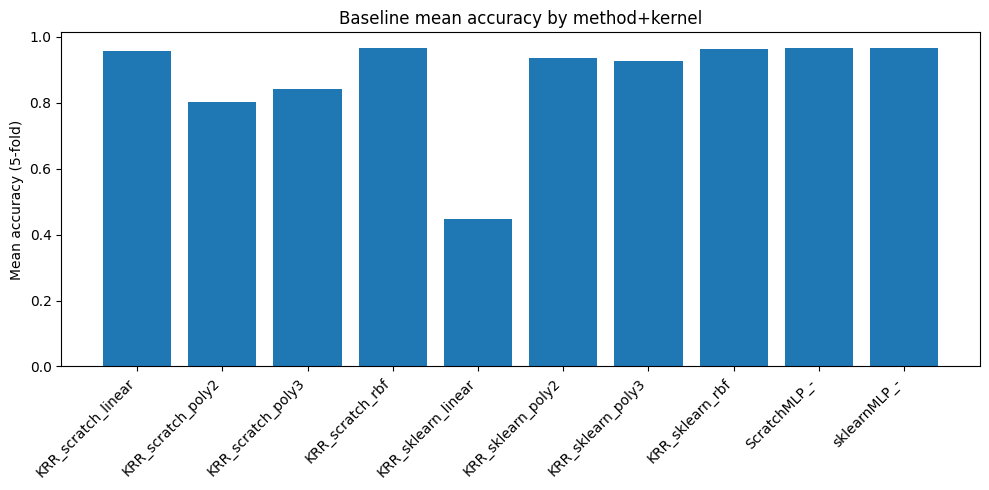

In [4]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_ridge import KernelRidge

class ScratchMLP:
    def __init__(self, input_size, hidden_size=16, lr=0.05, seed=123):
        np.random.seed(seed)
        self.lr = lr
        self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, 1) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, 1))

    def sigmoid(self, x):
        x = np.clip(x, -250, 250)
        return 1.0 / (1.0 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.z1 = X.dot(self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1.dot(self.w2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, yhat):
        m = X.shape[0]
        dz2 = (yhat - y) / m
        dw2 = self.a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2.dot(self.w2.T)
        dz1 = da1 * self.relu_derivative(self.z1)
        dw1 = X.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        return dw1, db1, dw2, db2

    def update(self, grads):
        dw1, db1, dw2, db2 = grads
        self.w1 -= self.lr * dw1
        self.b1 -= self.lr * db1
        self.w2 -= self.lr * dw2
        self.b2 -= self.lr * db2

    def fit(self, X, y, epochs=80, batch_size=64, verbose=False):
        n = X.shape[0]
        y = y.reshape(-1,1)
        for epoch in range(epochs):
            perm = np.random.permutation(n)
            X_shuf = X[perm]
            y_shuf = y[perm]
            for i in range(0, n, batch_size):
                xb = X_shuf[i:i+batch_size]
                yb = y_shuf[i:i+batch_size]
                yhat = self.forward(xb)
                grads = self.backward(xb, yb, yhat)
                self.update(grads)

    def predict_proba(self, X):
        return self.forward(X).ravel()

    def predict(self, X, thresh=0.5):
        return (self.predict_proba(X) >= thresh).astype(int).reshape(-1,1)

def linear_kernel(A, B):
    return A.dot(B.T)

def poly_kernel(A, B, degree=2, coef0=1.0):
    return (A.dot(B.T) + coef0) ** degree

def rbf_kernel(A, B, gamma):
    A2 = np.sum(A**2, axis=1).reshape(-1,1)
    B2 = np.sum(B**2, axis=1).reshape(1,-1)
    dists = A2 + B2 - 2 * A.dot(B.T)
    return np.exp(-gamma * dists)

class KernelRidgeScratch:
    def __init__(self, kernel='linear', lam=1e-2, degree=2, coef0=1.0, gamma=None):
        self.kernel = kernel
        self.lam = lam
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma

    def _kernel(self, A, B):
        if self.kernel == 'linear':
            return linear_kernel(A, B)
        elif self.kernel == 'poly':
            return poly_kernel(A, B, degree=self.degree, coef0=self.coef0)
        elif self.kernel == 'rbf':
            g = self.gamma if self.gamma is not None else 1.0 / A.shape[1]
            return rbf_kernel(A, B, g)
        else:
            raise ValueError("unknown kernel")

    def fit(self, X, y):
        self.X_train = X.copy()
        y = y.reshape(-1)
        self.y_mean = np.mean(y)
        y_center = y - self.y_mean
        K = self._kernel(self.X_train, self.X_train)
        n = K.shape[0]
        A = K + self.lam * np.eye(n)
        self.alpha = np.linalg.solve(A, y_center)

    def predict(self, X):
        Kt = self._kernel(X, self.X_train)
        return Kt.dot(self.alpha) + self.y_mean

def eval_metrics(y_true, y_pred):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

def run_5fold_comparison(noise_std=0.0, random_state=42, verbose=False):
    data = load_breast_cancer()
    X_all = data.data.copy()
    y_all = data.target.reshape(-1,1).astype(float)

    if noise_std > 0.0:
        rng = np.random.RandomState(0)
        X_all = X_all + rng.normal(scale=noise_std, size=X_all.shape)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    records = []

    fold = 0
    for train_idx, test_idx in skf.split(X_all, y_all.ravel()):
        fold += 1
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        mlp_s = ScratchMLP(input_size=X_train_s.shape[1], hidden_size=16, lr=0.05, seed=123+fold)
        t0 = time.time()
        mlp_s.fit(X_train_s, y_train.ravel(), epochs=80, batch_size=64)
        t_train = time.time() - t0
        t0 = time.time()
        y_pred = mlp_s.predict(X_test_s)
        t_test = time.time() - t0
        m = eval_metrics(y_test, y_pred)
        records.append({
            'fold': fold, 'method': 'ScratchMLP', 'kernel': '-', 'noise_std': noise_std,
            'accuracy': m['accuracy'], 'precision': m['precision'], 'recall': m['recall'], 'f1': m['f1'],
            'train_time': t_train, 'test_time': t_test
        })
        if verbose: print(f"[fold{fold}] ScratchMLP acc={m['accuracy']:.4f}")

        mlp_sk = MLPClassifier(hidden_layer_sizes=(16,), activation='relu', solver='lbfgs',
                                learning_rate_init=0.05, max_iter=200, tol=1e-6, random_state=123)
        t0 = time.time()
        mlp_sk.fit(X_train_s, y_train.ravel())
        t_train = time.time() - t0
        t0 = time.time()
        y_pred = mlp_sk.predict(X_test_s).reshape(-1,1)
        t_test = time.time() - t0
        m = eval_metrics(y_test, y_pred)
        records.append({
            'fold': fold, 'method': 'sklearnMLP', 'kernel': '-', 'noise_std': noise_std,
            'accuracy': m['accuracy'], 'precision': m['precision'], 'recall': m['recall'], 'f1': m['f1'],
            'train_time': t_train, 'test_time': t_test
        })
        if verbose: print(f"[fold{fold}] sklearnMLP acc={m['accuracy']:.4f}")

        kr_variants = [
            ('linear', {'kernel':'linear'}),
            ('poly2', {'kernel':'poly','degree':2}),
            ('poly3', {'kernel':'poly','degree':3}),
            ('rbf', {'kernel':'rbf','gamma':1.0/X_train_s.shape[1]})
        ]
        lam = 1e-2
        for name, params in kr_variants:
            kr_s = KernelRidgeScratch(kernel=params['kernel'], lam=lam, degree=params.get('degree',2),
                                      coef0=1.0, gamma=params.get('gamma', None))
            t0 = time.time()
            kr_s.fit(X_train_s, y_train.ravel())
            t_train = time.time() - t0
            t0 = time.time()
            y_cont = kr_s.predict(X_test_s)
            y_pred = (y_cont >= 0.5).astype(int).reshape(-1,1)
            t_test = time.time() - t0
            m = eval_metrics(y_test, y_pred)
            records.append({
                'fold': fold, 'method': 'KRR_scratch', 'kernel': name, 'noise_std': noise_std,
                'accuracy': m['accuracy'], 'precision': m['precision'], 'recall': m['recall'], 'f1': m['f1'],
                'train_time': t_train, 'test_time': t_test
            })

            if name == 'linear':
                kr_sk = KernelRidge(alpha=lam, kernel='linear')
            elif name.startswith('poly'):
                deg = params.get('degree',2)
                kr_sk = KernelRidge(alpha=lam, kernel='polynomial', degree=deg, coef0=1.0)
            else:
                kr_sk = KernelRidge(alpha=lam, kernel='rbf', gamma=params.get('gamma'))

            t0 = time.time()
            kr_sk.fit(X_train_s, y_train.ravel())
            t_train = time.time() - t0
            t0 = time.time()
            y_cont = kr_sk.predict(X_test_s)
            y_pred = (y_cont >= 0.5).astype(int).reshape(-1,1)
            t_test = time.time() - t0
            m = eval_metrics(y_test, y_pred)
            records.append({
                'fold': fold, 'method': 'KRR_sklearn', 'kernel': name, 'noise_std': noise_std,
                'accuracy': m['accuracy'], 'precision': m['precision'], 'recall': m['recall'], 'f1': m['f1'],
                'train_time': t_train, 'test_time': t_test
            })

    df = pd.DataFrame.from_records(records)
    return df

if __name__ == "__main__":
    print("Loading dataset and running 5-fold CV (baseline)...")
    df_baseline = run_5fold_comparison(noise_std=0.0, verbose=False)

    data = load_breast_cancer()
    noise_std = 0.1 * data.data.std(axis=0).mean()
    print(f"Running 5-fold CV with Gaussian noise (std={noise_std:.4f}) ...")
    df_noisy = run_5fold_comparison(noise_std=noise_std, verbose=False)

    def summarize(df):
        return df.groupby(['method','kernel','noise_std']).agg(
            accuracy_mean=('accuracy','mean'), accuracy_std=('accuracy','std'),
            precision_mean=('precision','mean'), recall_mean=('recall','mean'), f1_mean=('f1','mean'),
            train_time_mean=('train_time','mean'), test_time_mean=('test_time','mean')
        ).reset_index()

    summary_baseline = summarize(df_baseline)
    summary_noisy = summarize(df_noisy)

    print("\n--- Baseline summary (5-fold mean) ---")
    print(summary_baseline.to_string(index=False))

    print("\n--- Noisy summary (5-fold mean) ---")
    print(summary_noisy.to_string(index=False))

    plt.figure(figsize=(10,5))
    labels = summary_baseline['method'] + "_"+ summary_baseline['kernel'].astype(str)
    accs = summary_baseline['accuracy_mean'].values
    x = np.arange(len(labels))
    plt.bar(x, accs)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Mean accuracy (5-fold)')
    plt.title('Baseline mean accuracy by method+kernel')
    plt.tight_layout()
    plt.show()
